In [12]:
#!pip install torch numpy matplotlib seaborn

In [13]:
"""
如何看代码
1 句子token
2 token后embedding
3 

class类 的使用方式
1 实例化时，实例化给赋值
2 用的时候，把 forward传入进去
"""

'\n如何看代码\n1 句子token\n2 token后embedding\n3 \n\nclass类 的使用方式\n1 实例化时，实例化给赋值\n2 用的时候，把 forward传入进去\n'

In [14]:
import math,torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable #变量封装函数

In [26]:
#0-输入数据，矩阵化后 传入到 encoder

#数据token后，进行embedding
class Embedding(nn.Module):
    def __init__(self, d_model,vocab):
        super(Embedding,self).__init__()
        self.lut=nn.Embedding(vocab,d_model)
        self.d_model=d_model
    def forward(self,x):
        return self.lut(x)*math.sqrt(self.d_model)
'''
embedding = Embedding(10,30)
input=torch.tensor([[1,2,4,5],[5,2,5,6]],dtype=torch.long)
embedding(input)
'''

#position emb
#如何计算？找模板pe，位置矩阵形状；设计计算方式position
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(p=dropout)

        #初始化一行0阵
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len).unsqueeze(1) #位置；第二维度变为1；本来是一维，第二维扩充变为二维

        div_term=torch.exp(torch.arange(0,d_model,2)*-(math.log(10000)/d_model))
        # 位置*-10000相关
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)

        pe=pe.unsqueeze(0) #扩展为embedding相同维度

        self.register_buffer("pe",pe) #不被优化的超参数
    def forward(self,x):
        x = x + self.pe[:x.size(1), :].to(x.device)
        #取了batch分块中，最长的pos，不需要max_len
        #pe[:,:]是切片，0-n维度
        return self.dropout(x)

d_model=512
dropout=0.1
max_len=60



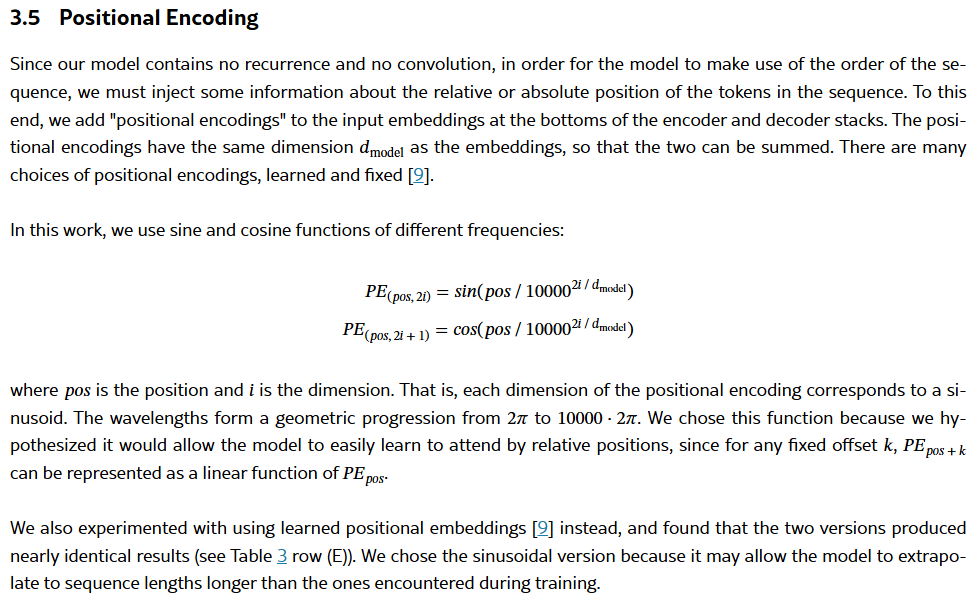
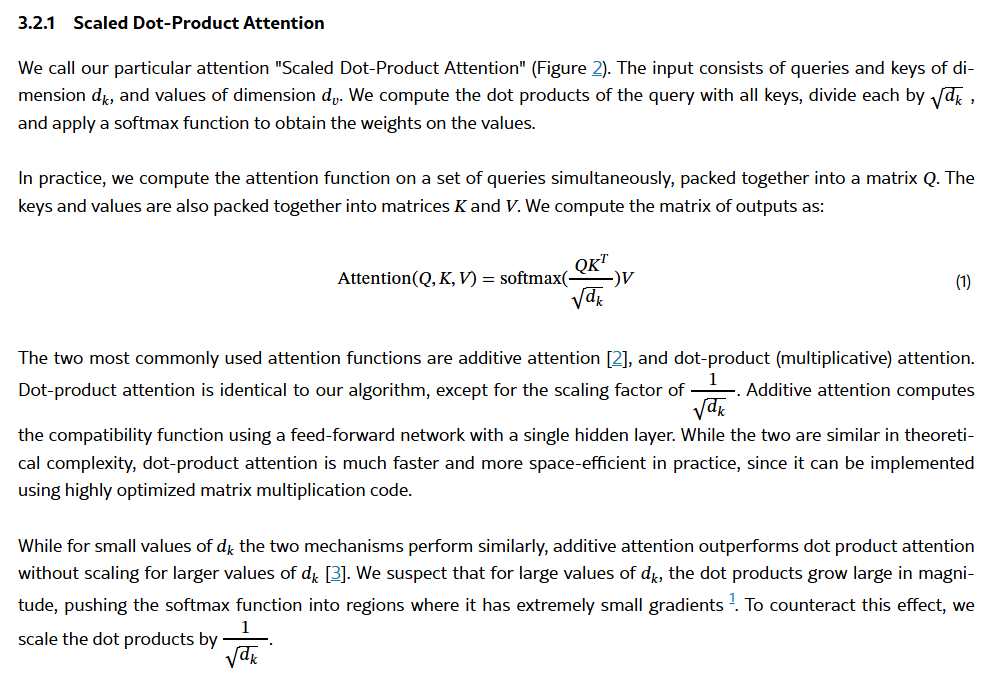

In [27]:
import copy

#生成掩码
def subsequent_mask(size):
    attn_shape=(1,size,size)
    subsequent_mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
    # k=1掩码的位置，在对角线上下浮动
    return torch.from_numpy(1-subsequent_mask)

#self_attention
def attention(query,key,value,mask=None,dropout=None):
    d_k=query.size(-1) #行大小
    scores=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    
    if mask is not None:
        scores=scores.masked_fill(mask==0,-1e9)
    p_attn=F.softmax(scores,dim=-1)
    
    if dropout is not None:
        p_attn=dropout(p_attn)
    
    return torch.matmul(p_attn,value),p_attn

def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#mutli-head
#forward 中的qkv是什么？就是分头后的输入序列
# 怎么输入进来的 QKV：通过x模版，以及拆头和转置造成
class MultiHeadedAttention(nn.Module):
    def __init__(self,head,embedding_dim,dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        assert embedding_dim %head ==0 
        self.d_k = embedding_dim //head
        self.haed=head
        self.linears=clones(nn.Linear(embedding_dim,embedding_dim),4)#copy qkv，这一步是qkv的站位符号。
        self.attn=None

    def forward(self,query,key,value,mask=None):
        if mask is not None:
            mask=mask.unsqueeze(1)
        batch_size=query.size(0) #分块后输入数据的头部
        query,key,value=[
            model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2) for model,x in zip(self.linears,(query,key,value))
        ]
        x,self_attn=attention(query,key,value,mask=mask,dropout=self.dropout)
        # multi-head计算完后，进入到x中计算
        x=x.transpose(1,2).contiguous().view(batch_size,-1,self.head,*self.d_model)
        return self.linears[-1](x)
'''
head=8
embedding_dim=512
dropout=0.1
mask=Variable(torch.zeros(8,4,4))
q=k=v=pe_results#这是token+pos后的向量
mha=MultiHeadedAttention(head,embedding_dim,dropout)
mha_result=mha(q,k,v,mask)
'''

'\nhead=8\nembedding_dim=512\ndropout=0.1\nmask=Variable(torch.zeros(8,4,4))\nq=k=v=pe_results#这是token+pos后的向量\nmha=MultiHeadedAttention(head,embedding_dim,dropout)\nmha_result=mha(q,k,v,mask)\n'

In [28]:
#FFNN 形状变化，输入层、隐藏层（可以有一个或多个）和输出层
"""
前馈连接层 模型改变
规范化层 (x-u)/std

nn.Parameter 封装为nn模型
"""
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model,d_ff,dropout=0.1):
        super(PositionwiseFeedForward,self).__init__()
        self.w1=nn.Linear(d_model,d_ff)
        self.w2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x):
        return self.w2(self.dropout(F.relu(self.w1(x))))

class LayerNorm(nn.Module):
    def __init__(self, d_model,eps=1e-6):
        super(LayerNorm,self).__init__()

        self.a2=nn.Parameter(torch.ones(d_model))
        self.b2=nn.Parameter(torch.zeros(d_model))
        self.eps=eps

    def forward(self,x):
        mean=x.mean(-1,keepdim=True)
        std=x.std(-1,keepdim=True)
        return self.a2*(x-mean)/(std+self.eps)+self.b2

In [29]:
#子层连接 class连接到一起
#实现方式 x+子层，标准化层在return中输入
"""
layernorm 归一化计算
"""
class SublayerConnection(nn.Module):
    def __init__(self, d_model,dropout=0.1):
        super(SublayerConnection,self).__init__()

        self.norm=LayerNorm(d_model)
        self.dropout=nn.Dropout(p=dropout)

    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))
"""
x=pe_result
mask=mask

self_attn=MultiHeadedAttention(head,d_model)

sublayer=lambda x:self_attn(x,x,x,mask)
sc=SublayerConnection(d_model,dropout)
sc(x,sublayer)
"""

'\nx=pe_result\nmask=mask\n\nself_attn=MultiHeadedAttention(head,d_model)\n\nsublayer=lambda x:self_attn(x,x,x,mask)\nsc=SublayerConnection(d_model,dropout)\nsc(x,sublayer)\n'

In [30]:
#encode层
#从token+pos input，到encoder输出
class EncoderLayer(nn.Module):
    def __init__(self, size,d_model,self_attn,feed_forward,dropout):
        super(EncoderLayer,self).__init__()

        self.self_attn=self_attn # 多头
        self.feed_forward=feed_forward #FFNN
        self.sublayer=clones(SublayerConnection(d_model,dropout),2)
        self.size=size
    
    def forward(self,x,mask):
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward) #这里没有LM层，在后面encode加上

#里面所有内容需要实例化，self_attn多头


In [31]:
#encoder层
#流程：clone N份
class Encoder(nn.Module):
    def __init__(self, layer,N):
        super(Encoder,self).__init__()
        self.layer=clones(layer,N) #EncoderLayer 也就是总层个数
        self.norm=LayerNorm(layer.size)

    def forward(self,x,mask):
        for layer in self.layer:
            x=layer(x,mask)
        return self.norm(x)

In [ ]:
#decoder
# 使用之前已经构建好的 多头，FFNN，LM层
class DecoderLayer(nn.Module):
    def __init__(self,d_model,self_attn,src_attn,feed_forward,dropout):
        super(DecoderLayer,self).__init__()

        self.d_model=d_model
        self.self_attn=self_attn
        self.src_attn=src_attn
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(d_model,dropout),3) #单一子层复制
    
    def forward(self,x,memory,source_mask,target_mask):
        m=memory # k v 
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        x=self.sublayer[1](x,lambda x:self.src_attn(x,m,m,source_mask))
        return self.sublayer[2](x,self.feed_forward)

In [25]:
class Decoder(nn.Module):
    def __init__(self,layer,N):
        super(Decoder,self).__init__()

        self.layer=clones(layer,N)
        self.norm=LayerNorm(layer,d_model)

    def forward(self,x,memory,source_mask,target_mask):
        for layer in self.layer:
            x=layer(x,memory,source_mask,target,mask)
            return self.norm(x)

In [ ]:
# 输出层linear softmax
class Generator(nn.Module):
    def __init__(self,d_model,vocab_size):
        super(Generator,self).__init__()
        self.project=nn.Linear(d_model,vocab_size)
    
    def forward(self,x):
        return F.log_softmax(self.project(x),dim=-1)

In [ ]:
#总体架构
"""
source_embed 作用是什么？
"""
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,source_embed,target_embed,generator):
        super(EncoderDecoder,self).__init__()

        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=source_embed
        self.tgt_embed=target_embed
        self.generator=generator

    def forward(self,source,target,source_mask,target_mask):
        return self.decode(self.encode(source,source_mask),source_mask,target,target_mask)

    def encode(self,source,source_mask):
        return self.encoder(self,src_embed(source),source_mask) #x mask
    
    def decode(self,memory,source_mask,target,target_mask):
        return self.decoder(self,tgt_embed(target),memory,source_mask,target_mask)

In [33]:
# 超参数-完整模型函数
"""
整个流程需要翻译
position的作用？
编写出来整个流程
"""
def make_model(source_vocab,target_vocab,N=6,d_model=512,d_ff=2048,head=8,dropout=0.1):
    c=copy.deepcopy

    position=PositionalEncoding(d_model,dropout)
    attn=MultiHeadedAttention(head,d_model)
    ff=PositionwiseFeedForward(d_model,dropout)
    model=EncoderDecoder(
        Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
        Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
        nn.Sequential(Embedding(d_model,src_vocab),c(position)),
        nn.Sequential(Embedding(d_model,tgt_vocab),c(position)),
        Generator(d_model,tgt_vocab)
    )
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model